# Tutorial: Effects of radiation and temperature on stainless steel

This tutorial will use the `materials` library to explore how neutron irradiation changes the material properties of AISI 304 stainless steel.

First, let's import some modules from the `materials` library, and `pyplot` for plotting:

In [1]:
import os.path
import numpy as np
%matplotlib notebook
from matplotlib import pyplot as plt
import materials
from materials import plot_utils

## Load and examine a material data object
Now, load the material properties of AISI 304 stainless steel:

In [2]:
filename = os.path.join(materials.get_database_dir(), 'AISI_304.yaml')
aisi304 = materials.load_from_yaml(filename, 'sheet and strip', 'annealed')
print(aisi304)

AISI 304
--------
metal, stainless steel

Elemental composition:
Element:            Fe     Cr     Ni     Mn     Si      C      P      S
Max % by mass:    74.00   20.00   10.50   2.00   1.00   0.08   0.04   0.03
Min % by mass:    66.34   18.00   8.00   0.00   0.00   0.00   0.00   0.00

Properties for the "sheet and strip" form, "annealed" condition:
density = 7916 kg m^-3 [Data from mmpds01]

poissons_ratio = 0.27 dimensionless [Data from mmpds01]

youngs_modulus, a state-dependent property with a default value of 200 GPa
	and with the following variation-with-state models:
 - thermal: Variation with temperature over 295 to 922 kelvin', represented as a table. [Data from mmpds01]

thermal_expansion_linear, a state-dependent property with a default value of 15.5 1e-6 K^-1
	and with the following variation-with-state models:
 - thermal: Variation with temperature over 19.11 to 1142 kelvin', represented as a table. [Data from mmpds01]

heat_capacity, a state-dependent property with a defa

Above we see a summary of the available data on AISI 304. The material has a set of properties. Some properties are state-dependent. Each state-dependent property has one or more "variation with state" models, which describe how the property changes with some state variables. We are interested in `strength_tensile_yield` and `elongation`; specifically their `radiation` models which quantify the variation of these properties over a range of temperatures and neutron doses. (The data behind these models is a lookup table of experiments from [1]).

## Query the value of a material property
Let's query the values of yield tensile strength and elongation at failure at a temperature of 400 K and a neutron dose of $10^{20} \mathrm{cm}^{-2}$.

In [3]:
yts = aisi304['strength_tensile_yield'].query_value(
            {'temperature': 400, 'neutron dose': 1e20}, 'radiation')
print('YTS = {:.0f} {:s}'.format(yts, aisi304['strength_tensile_yield'].units))
elong = aisi304['elongation'].query_value(
            {'temperature': 400, 'neutron dose': 1e20}, 'radiation')
print('elongation = {:.0f} {:s}'.format(elong, aisi304['elongation'].units))


YTS = 463 MPa
elongation = 38 percent


## Intuitions for radiation damage
Irradiation will make stainless steel stronger (higher yield tensile strength) but more brittle (lower elongation at failure). We can get some intuition for why this occurs from a (hand-wavy) argument about dislocations in the material.

In order for a metal to plastically deform, dislocations in the metal's crystal structure must move. If it is harder for the dislocations to move, it will be harder to plastically deform the material, so the yield strength will be higher. In some metals, the dislocations get 'stuck' on each other, so if there are more dislocations, it is harder for the defects to move.  Cold working introduces dislocations into the metal. Thus, some metals (including austenitic stainless steels like 304) can be strengthened by cold working. However, adding dislocations makes it easier to break the material, so cold working will reduce the elongation at failure.

Dislocations can be removed by heat. If we heat the material, there will be enough thermal energy allow atoms to migrate in the crystal lattice. The atoms will move to restore dislocation-free lattices, as this is the lower energy state. This process is called annealing. Annealed stainless steel is less strong but more ductile (longer elongation at break).

Neutron irradiation also adds dislocations to the material. When an energetic neutron interacts with a nucleus, it can knock the nucleus out of place in the lattice. Thus, neutron irradiation, like cold working, makes stainless steel stronger but more brittle. The effects of neutron irradiation should be less noticeable if the temperature is high enough to anneal out the neutron-induced dislocations.

Again, this is just a hand-wavy argument, we will see that there is a lot more going on in reality.

## Plotting strength and elongation versus neutron does and temperature
Let's plot some data on the properties of AISI 304, and see if the plots match the intuition described above:

<IPython.core.display.Javascript object>


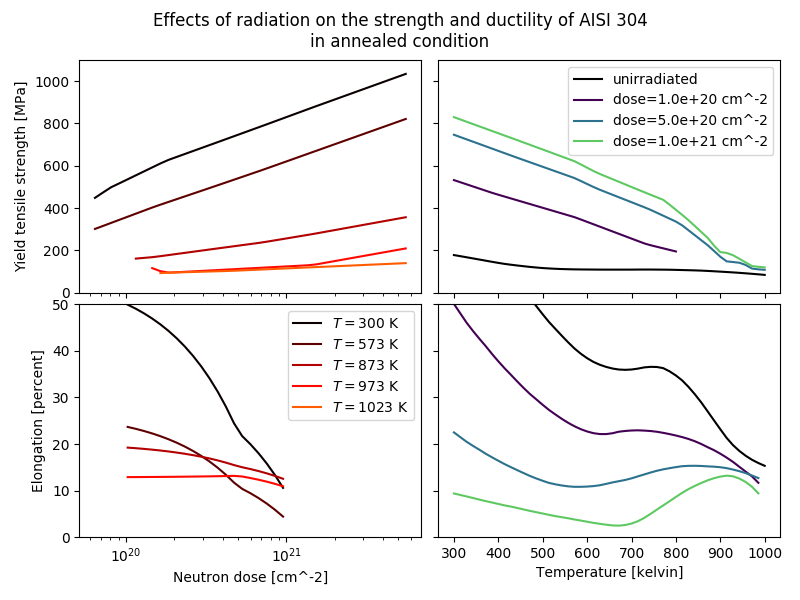

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row', figsize=(8, 6))

# Plots versus dose w/ contours of temperature
dose = np.logspace(19.5, 22)
temperatures = np.array([300, 300+273, 600+273, 700+273, 1023])
colors = plt.cm.hot(np.linspace(0, 0.5, len(temperatures)))
for (temp, color) in zip(temperatures, colors):
    yts = aisi304['strength_tensile_yield'].query_value(
        {'temperature': temp, 'neutron dose': dose}, 'radiation')
    elong = aisi304['elongation'].query_value(
        {'temperature': temp, 'neutron dose': dose}, 'radiation')
    axes[0, 0].semilogx(dose, yts, label='$T={:.0f}$ K'.format(temp), color=color)
    axes[1, 0].semilogx(dose, elong, label='$T={:.0f}$ K'.format(temp), color=color)
xunits = aisi304['strength_tensile_yield']['radiation'].state_vars_units['neutron dose']
yunits = aisi304['strength_tensile_yield'].units
axes[0, 0].set_ylabel('Yield tensile strength [{:s}]'.format(yunits))
axes[0, 0].set_ylim([0, 1100.])

yunits = aisi304['elongation'].units
axes[1, 0].set_xlabel('Neutron dose [{:s}]'.format(xunits))
axes[1, 0].set_ylabel('Elongation [{:s}]'.format(yunits))
axes[1, 0].set_ylim([0, 50.])
axes[1, 0].legend()

# Plots versus temperature - unirradiated
doses = np.array([1e20, 5e20, 1e21])
temperature = np.linspace(300, 1000)
yts = aisi304['strength_tensile_yield'].query_value(
        {'temperature': temperature}, 'thermal')
elong = aisi304['elongation'].query_value(
        {'temperature': temperature}, 'thermal')
axes[0, 1].plot(temperature, yts, label='unirradiated', color='black')
axes[1, 1].plot(temperature, elong, label='unirradiated', color='black')

# Plots versus temperature with contours of dose
colors = plt.cm.viridis(np.linspace(0, 0.75, len(doses)))
for (dose, color) in zip(doses, colors):
    yts = aisi304['strength_tensile_yield'].query_value(
        {'temperature': temperature, 'neutron dose': dose}, 'radiation')
    elong = aisi304['elongation'].query_value(
        {'temperature': temperature, 'neutron dose': dose}, 'radiation')
    axes[0, 1].plot(temperature, yts, label='dose={:.1e} cm^-2'.format(dose), color=color)
    axes[1, 1].plot(temperature, elong, label='dose={:.1e} cm^-2'.format(dose), color=color)
axes[0, 1].legend()
xunits = aisi304['strength_tensile_yield']['radiation'].state_vars_units['temperature']
axes[1, 1].set_xlabel('Temperature [{:s}]'.format(xunits))

plt.suptitle('Effects of radiation on the strength and ductility of {:s}'.format(aisi304.name)
    + '\nin {:s} condition'.format(aisi304.condition))
plt.tight_layout()
plt.subplots_adjust(top=0.90, hspace=0.05, wspace=0.05)
plt.show()

The figure confirms some expected trends:
1. Strength decreases with increasing temperature (top-right subplot)
2. Strength increases with increasing neutron dose (top-left subplot)
3. Elongation decreases with increasing neutron dose (bottom-left subplot)
4. The contours of different doses (right subplots) are far apart at low temperatures, and closer together at high temperatures. The effects of neutron irradiation are less significant at high temperatures.

These observations agree with our hand-wavy model. However, the plots show some features our model cannot explain; e.g. the elongation vs temperature curves at high doses (bottom-right subplot, green and blue curves) are non-monotonic. What's up with that?

## Reality is more complicated...
There is a lot more going on than our simple model described. For one, neutron irradiation does not just cause dislocations, it can also generate helium within the metal, which has complicated damaging effects.

Also, the effects of neutron irradiation depend on the temperature at which the irradiation occurred. In the dataset used for the plots above, all samples were *irradiated* at 290 C (563 K), but were then *tensile tested* at various temperatures. Irradiation at a different temperature could lead to different results. 

Irradiation can also interact with corrosion, which was not addressed here.

Additionally, the effects depend not just on the fluence of neutrons, but also on their energy spectrum. The above doses refer to the total fluence of neutrons with energies $> 1$ MeV in an exposure conducted in the Engineering Test Reactor, which was fission reactor at the Idaho National Laboratory. A different type of reactor may have a different neutron spectrum, which could cause a different relationship between neutron fluence and material properties.

## References
The irradiation data is from:

[1] Irvin, J. E. and A. L. Bement, "Nature of Radiation Damage to Engineering Properties of Various Stainless Steel Alloys", in *Effects of Radiation on Structural Materials*, America Society for Testing and Materials, 1967.